In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.nn as nn
import torch.optim as optim
import time
import copy
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import torch.nn as nn
from NestedImageFolder import NestedImageFolder

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#zip_path = '/content/drive/MyDrive/AI_Techniques_Dataset.zip'
#extract_to = '/content/drive/MyDrive/AI_Techniques_Dataset'

#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_to)

#print("Extraction completed.")


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
# class NestedImageFolder(datasets.ImageFolder):
#     def __init__(self, *args):
#         super().__init__(*args)

#     def find_classes(self, dir):
#         it = sorted(os.walk(dir))
    
#         classes = [x[0][len(dir)+1:] for x in it]
#         classes = [x for x in classes if (x.count("/") == 2)]

#         asdict = {}
#         for i, k in enumerate(classes):
#             asdict[k] = i
        
#         return classes, asdict


In [6]:
# data_dir = 'GroceryStoreDataset/dataset'
data_dir = '/Users/syahirghariff/Space/UM/WQF7002 AIT/Project/GroceryStoreDataset-master2/dataset'
# image_datasets = {x: NestedImageFolder(os.path.join(data_dir, x),data_transforms[x])
#                   for x in ['train', 'val', 'test']}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

mydevice = "cpu"

if torch.cuda.is_available():
    mydevice = "cuda:0"
elif torch.backends.mps.is_available():
    mydevice = "mps"

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device(mydevice) 

In [7]:
device

device(type='mps')

In [8]:
class_names

['Avocado', 'Orange', 'Pineapple']

In [9]:
model = models.vgg16(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(num_features, len(class_names))])
model.classifier = nn.Sequential(*features)

mydevice = "cpu"

if torch.cuda.is_available():
    mydevice = "cuda:0"
elif torch.backends.mps.is_available():
    mydevice = "mps"

device = torch.device(mydevice) 
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/Users/syahirghariff/anaconda3/envs/ait-project/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/syahirghariff/anaconda3/envs/ait-project/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model.parameters(), lr=0.001)

def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_acc, val_acc = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]
            # epoch_acc = epoch_acc.float()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
              train_acc.append(epoch_acc.item())
            else:
              val_acc.append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, train_acc, val_acc

In [11]:
model, train_acc, val_acc = train_model(model, criterion, optimizer_ft, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.5104 Acc: 0.9032
val Loss: 75.3735 Acc: 0.3500

Epoch 1/24
----------
train Loss: 0.9223 Acc: 0.9516
val Loss: 188.0190 Acc: 0.4000

Epoch 2/24
----------
train Loss: 0.3564 Acc: 0.9919
val Loss: 90.2593 Acc: 0.5000

Epoch 3/24
----------
train Loss: 10.6317 Acc: 0.9194
val Loss: 644.2318 Acc: 0.2000

Epoch 4/24
----------
train Loss: 0.0304 Acc: 0.9919
val Loss: 636.9729 Acc: 0.3000

Epoch 5/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 604.8754 Acc: 0.4000

Epoch 6/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 603.5619 Acc: 0.4000

Epoch 7/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 603.5075 Acc: 0.4000

Epoch 8/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 603.5049 Acc: 0.4000

Epoch 9/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 603.5049 Acc: 0.4000

Epoch 10/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 603.5049 Acc: 0.4000

Epoch 11/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 6

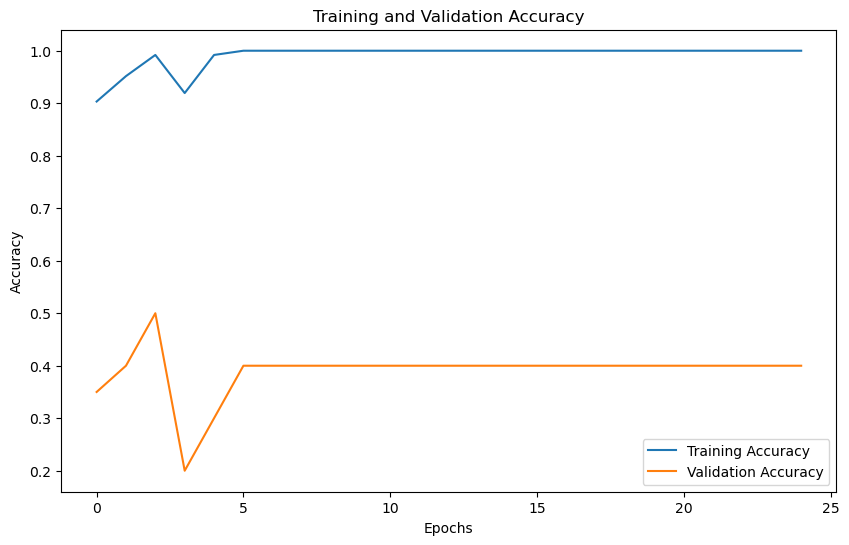

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
def test_model(model):
    model.eval()
    running_corrects = 0
    preds_all, labels_all = [], []

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)
        preds_all.extend(preds.view(-1).tolist())
        labels_all.extend(labels.view(-1).tolist())

    test_acc = running_corrects.float() / dataset_sizes['test']
    print(f'Test Acc: {test_acc:.4f}')

    cm = confusion_matrix(labels_all, preds_all)
    plot_confusion_matrix(cm, class_names)

Test Acc: 0.9174


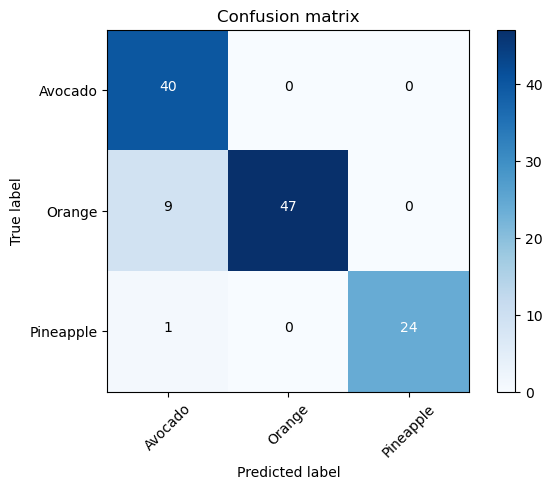

In [15]:
test_model(model)

In [16]:
# data_transforms2 = {
#     'predict': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),

# def predict(base64_string):
#     image_data = base64.b64decode(base64_string)
#     img = Image.open(BytesIO(image_data))
#     img = data_transforms2['predict'](img) 
    # model.eval()
    # running_corrects = 0
    # preds_all, labels_all = [], []

    # for inputs, labels in dataloaders['test']:
    #     inputs = inputs.to(device)
    #     labels = labels.to(device)

    #     with torch.no_grad():
    #         outputs = model(inputs)
    #         _, preds = torch.max(outputs, 1)

    #     running_corrects += torch.sum(preds == labels.data)
    #     preds_all.extend(preds.view(-1).tolist())
    #     labels_all.extend(labels.view(-1).tolist())

    # test_acc = running_corrects.float() / dataset_sizes['test']
    # print(f'Test Acc: {test_acc:.4f}')

    # cm = confusion_matrix(labels_all, preds_all)
    # plot_confusion_matrix(cm, class_names)

In [17]:
import torch
torch.save(model.state_dict(), 'vgg_fruit_classifier2.pth')

In [18]:
import pickle
pickle.dump(model, open('model2.pkl', 'wb'))